#                            III y IV Desarrollo y codigo

Librerias

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_decision_regions
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, plot_tree
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import KNeighborsClassifier
from scipy.spatial.distance import cdist
from matplotlib.colors import ListedColormap
from sklearn.svm import SVC

## Ejercicio 1

### Carga y limpieza de datos

In [23]:
column_names = ['ID', 'Diagnosis'] + [
    'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean',
    'compactness_mean', 'concavity_mean', 'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean',
    'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
    'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se', 'fractal_dimension_se',
    'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst',
    'compactness_worst', 'concavity_worst', 'concave_points_worst', 'symmetry_worst', 'fractal_dimension_worst'
]

df = pd.read_csv('wdbc.data', header=None, names=column_names)

print("Características del dataset:")
print(df.columns[2:])  # Excluyendo ID y Diagnosis
print("\nEtiquetas del dataset:")
print(df['Diagnosis'].unique())

Características del dataset:
Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave_points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

Etiquetas del dataset:
['M' 'B']


In [24]:
# Verificar valores faltantes
print("\nValores faltantes por columna:")
print(df.isnull().sum())


Valores faltantes por columna:
ID                         0
Diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave_points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave_points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave_points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64


In [27]:
# Verificamos outliers 
numeric_cols = df.columns[2:]  
Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1
outliers = ((df[numeric_cols] < (Q1 - 1.5 * IQR)) | (df[numeric_cols] > (Q3 + 1.5 * IQR))).sum()
print("\nOutliers potenciales por columna:")
print(outliers)


Outliers potenciales por columna:
radius_mean                14
texture_mean                7
perimeter_mean             13
area_mean                  25
smoothness_mean             6
compactness_mean           16
concavity_mean             18
concave_points_mean        10
symmetry_mean              15
fractal_dimension_mean     15
radius_se                  38
texture_se                 20
perimeter_se               38
area_se                    65
smoothness_se              30
compactness_se             28
concavity_se               22
concave_points_se          19
symmetry_se                27
fractal_dimension_se       28
radius_worst               17
texture_worst               5
perimeter_worst            15
area_worst                 35
smoothness_worst            7
compactness_worst          16
concavity_worst            12
concave_points_worst        0
symmetry_worst             23
fractal_dimension_worst    24
dtype: int64


In [28]:
# Contamos las muestras benignas y malignas
print("\nConteo de diagnósticos:")
print(df['Diagnosis'].value_counts())
benign_count = df[df['Diagnosis'] == 'B'].shape[0]
malign_count = df[df['Diagnosis'] == 'M'].shape[0]
print(f"Benignos (B): {benign_count}")
print(f"Malignos (M): {malign_count}")


Conteo de diagnósticos:
Diagnosis
B    357
M    212
Name: count, dtype: int64
Benignos (B): 357
Malignos (M): 212


### Procesamiento

In [29]:
X = df.iloc[:, 2:].values
y = df['Diagnosis'].values
y = np.where(y == 'M', 1, 0)  # Convertir a 1 (maligno) y 0 (benigno)

# Estandarización
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Separación en train/test (70/30)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


### Entrenamiento de modelos 

In [30]:
# KNN con diferentes valores de k
k_values = [1, 3, 5, 7, 9]
knn_models = {}
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    knn_models[k] = knn
    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"KNN con k={k}: Exactitud = {acc:.4f}")

# DMIN 
# Centroides
centroid_benign = X_train[y_train == 0].mean(axis=0)
centroid_malign = X_train[y_train == 1].mean(axis=0)

def dmin_predict(X, centroid_benign, centroid_malign):
    dist_benign = cdist(X, [centroid_benign], 'euclidean')
    dist_malign = cdist(X, [centroid_malign], 'euclidean')
    return np.where(dist_malign < dist_benign, 1, 0)

y_pred_dmin = dmin_predict(X_test, centroid_benign, centroid_malign)
acc_dmin = accuracy_score(y_test, y_pred_dmin)
print(f"\nDMIN: Exactitud = {acc_dmin:.4f}")

KNN con k=1: Exactitud = 0.9532
KNN con k=3: Exactitud = 0.9591
KNN con k=5: Exactitud = 0.9591
KNN con k=7: Exactitud = 0.9591
KNN con k=9: Exactitud = 0.9708

DMIN: Exactitud = 0.9357


### Reduccion de dimension con PCA


Número de componentes para 95% varianza: 10


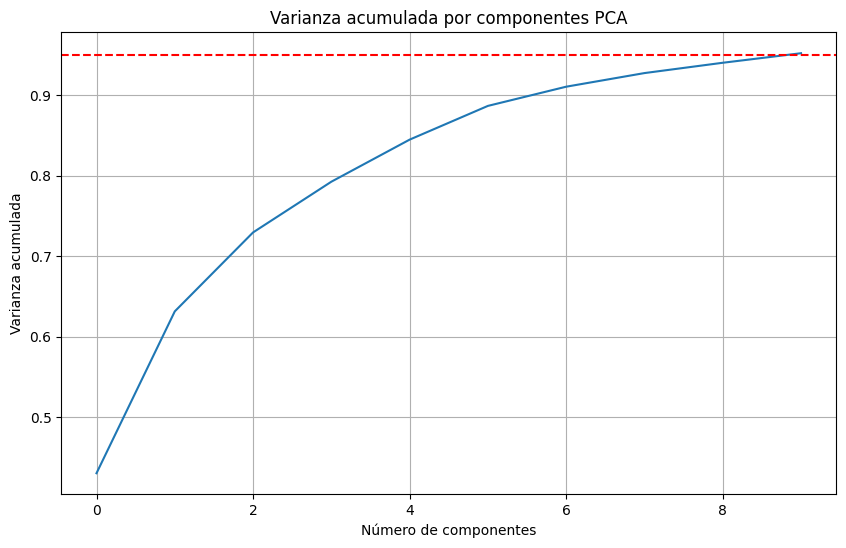

In [31]:
# Obtenemos el número de componentes para 95% de varianza
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
print(f"\nNúmero de componentes para 95% varianza: {pca.n_components_}")

# Gráfico de varianza acumulada
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axhline(y=0.95, color='r', linestyle='--')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza acumulada')
plt.title('Varianza acumulada por componentes PCA')
plt.grid()
plt.show()

In [32]:
# Entrenamos los modelos con datos reducidos
# KNN con datos reducidos
knn_pca_models = {}
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_pca, y_train)
    knn_pca_models[k] = knn
    y_pred = knn.predict(X_test_pca)
    acc = accuracy_score(y_test, y_pred)
    print(f"KNN (PCA) con k={k}: Exactitud = {acc:.4f}")

# DMIN con datos reducidos
centroid_benign_pca = X_train_pca[y_train == 0].mean(axis=0)
centroid_malign_pca = X_train_pca[y_train == 1].mean(axis=0)

y_pred_dmin_pca = dmin_predict(X_test_pca, centroid_benign_pca, centroid_malign_pca)
acc_dmin_pca = accuracy_score(y_test, y_pred_dmin_pca)
print(f"\nDMIN (PCA): Exactitud = {acc_dmin_pca:.4f}")

KNN (PCA) con k=1: Exactitud = 0.9532
KNN (PCA) con k=3: Exactitud = 0.9532
KNN (PCA) con k=5: Exactitud = 0.9649
KNN (PCA) con k=7: Exactitud = 0.9591
KNN (PCA) con k=9: Exactitud = 0.9708

DMIN (PCA): Exactitud = 0.9357


### Visualizacion de Resultados

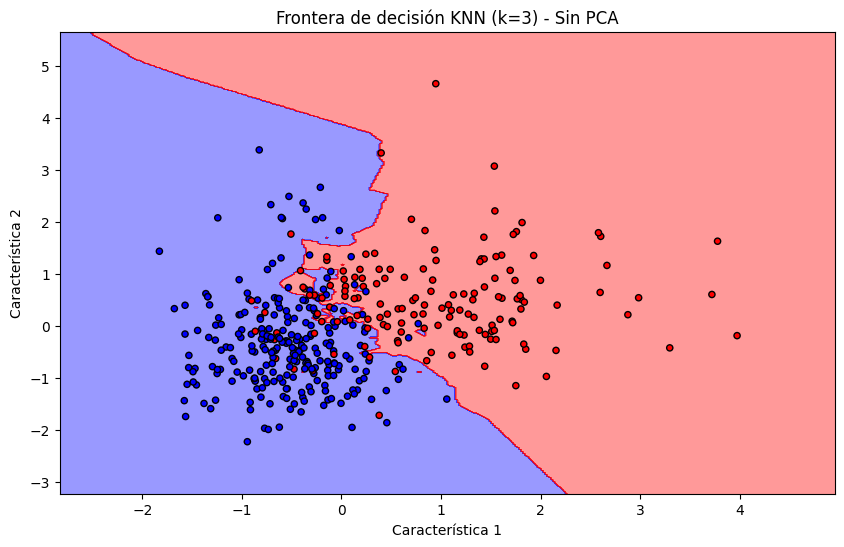

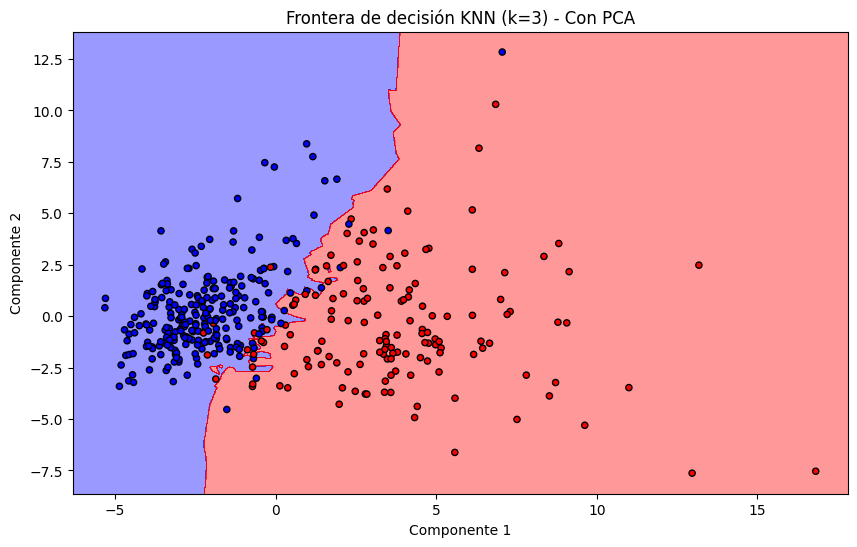

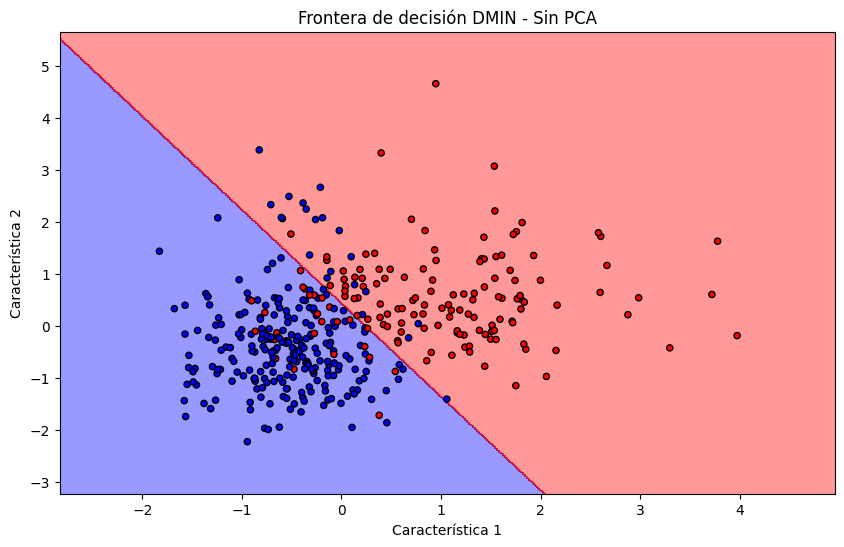

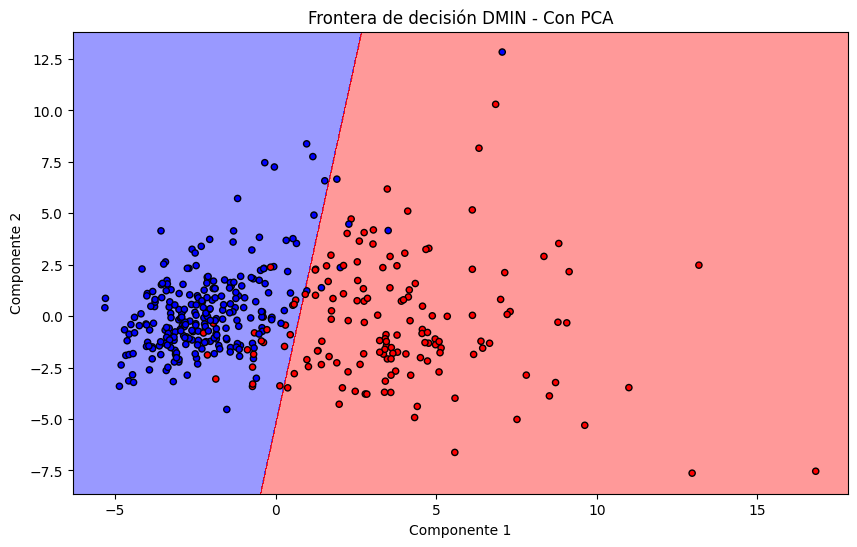

In [37]:
def plot_decision_boundary(model, X, y, title, pca_flag=False):
    # Reducir a 2D
    if not pca_flag:
        X_vis = X[:, :2]  # Usamos las primeras 2 características
    else:
        X_vis = X[:, :2]  # Ya está reducido por PCA, usamos primeros 2 componentes
    
    # Crear meshgrid
    h = .02  # step size in the mesh
    x_min, x_max = X_vis[:, 0].min() - 1, X_vis[:, 0].max() + 1
    y_min, y_max = X_vis[:, 1].min() - 1, X_vis[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Predecir para cada punto del meshgrid
    if model is not None:  # Para KNN
        # Creamos un modelo temporal solo para visualización
        model_vis = KNeighborsClassifier(n_neighbors=model.n_neighbors)
        model_vis.fit(X_vis, y)
        Z = model_vis.predict(np.c_[xx.ravel(), yy.ravel()])
    else:  # Para DMIN
        if pca_flag:
            centroid_b = centroid_benign_pca[:2]
            centroid_m = centroid_malign_pca[:2]
        else:
            centroid_b = centroid_benign[:2]
            centroid_m = centroid_malign[:2]
        
        Z = dmin_predict(np.c_[xx.ravel(), yy.ravel()], centroid_b, centroid_m)
    
    Z = Z.reshape(xx.shape)
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap=ListedColormap(('blue', 'red')))
    plt.scatter(X_vis[:, 0], X_vis[:, 1], c=y, s=20, edgecolor='k', cmap=ListedColormap(('blue', 'red')))
    plt.title(title)
    plt.xlabel('Componente 1' if pca_flag else 'Característica 1')
    plt.ylabel('Componente 2' if pca_flag else 'Característica 2')
    plt.show()

# Plotear fronteras para KNN k=3
plot_decision_boundary(knn_models[3], X_train, y_train, "Frontera de decisión KNN (k=3) - Sin PCA")
plot_decision_boundary(knn_pca_models[3], X_train_pca, y_train, "Frontera de decisión KNN (k=3) - Con PCA", True)

# Plotear fronteras para DMIN
plot_decision_boundary(None, X_train, y_train, "Frontera de decisión DMIN - Sin PCA")
plot_decision_boundary(None, X_train_pca, y_train, "Frontera de decisión DMIN - Con PCA", True)

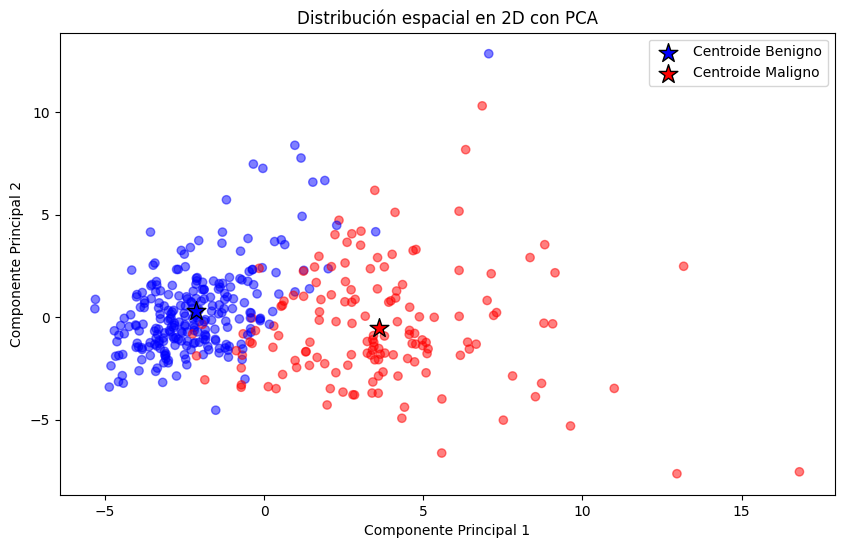

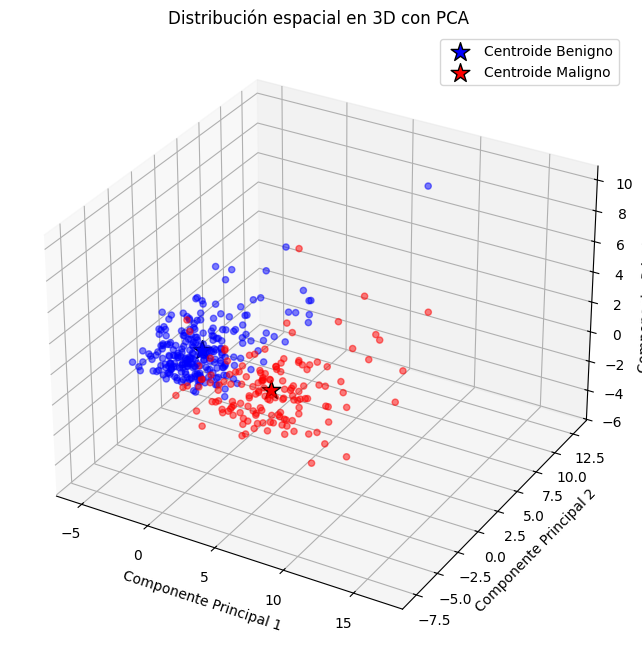

In [ ]:
# Distribución espacial y centroides en 2D y 3D
# 2D
plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap=ListedColormap(('blue', 'red')), alpha=0.5)
plt.scatter(centroid_benign_pca[0], centroid_benign_pca[1], s=200, marker='*', c='blue', edgecolor='k', label='Centroide Benigno')
plt.scatter(centroid_malign_pca[0], centroid_malign_pca[1], s=200, marker='*', c='red', edgecolor='k', label='Centroide Maligno')
plt.title('Distribución espacial en 2D con PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.show()

# 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], X_train_pca[:, 2], c=y_train, cmap=ListedColormap(('blue', 'red')), alpha=0.5)
ax.scatter(centroid_benign_pca[0], centroid_benign_pca[1], centroid_benign_pca[2], s=200, marker='*', c='blue', edgecolor='k', label='Centroide Benigno')
ax.scatter(centroid_malign_pca[0], centroid_malign_pca[1], centroid_malign_pca[2], s=200, marker='*', c='red', edgecolor='k', label='Centroide Maligno')
ax.set_title('Distribución espacial en 3D con PCA')
ax.set_xlabel('Componente Principal 1')
ax.set_ylabel('Componente Principal 2')
ax.set_zlabel('Componente Principal 3')
ax.legend()
plt.show()

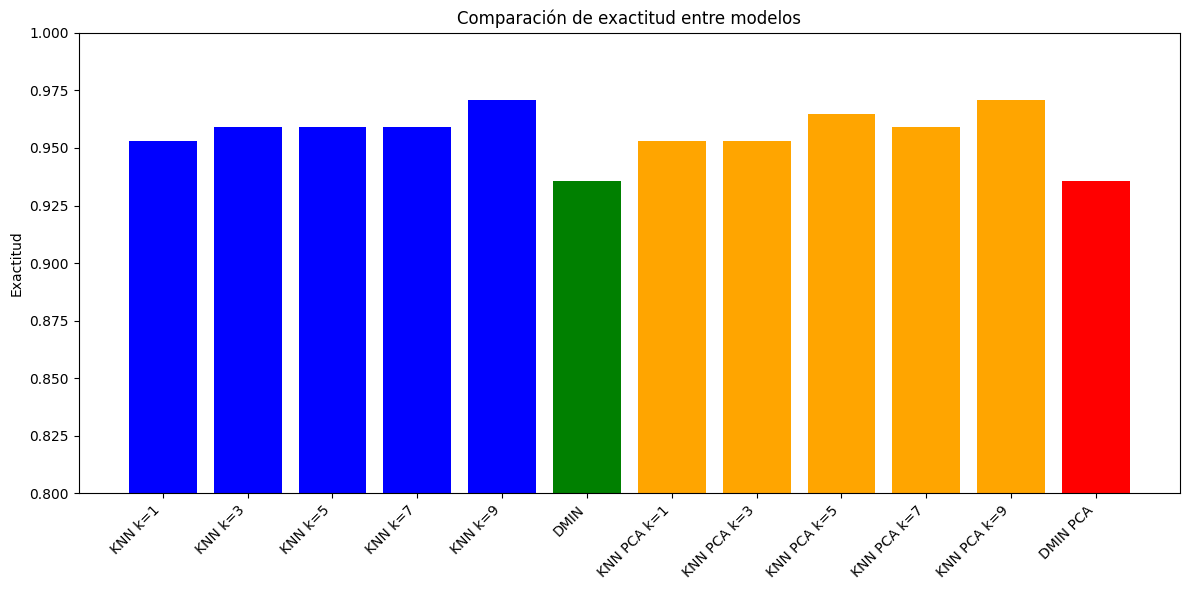

In [ ]:
# Gráfico comparativo de rendimiento
# Calcular exactitudes para todos los modelos
accuracies = {
    'KNN k=1': accuracy_score(y_test, knn_models[1].predict(X_test)),
    'KNN k=3': accuracy_score(y_test, knn_models[3].predict(X_test)),
    'KNN k=5': accuracy_score(y_test, knn_models[5].predict(X_test)),
    'KNN k=7': accuracy_score(y_test, knn_models[7].predict(X_test)),
    'KNN k=9': accuracy_score(y_test, knn_models[9].predict(X_test)),
    'DMIN': acc_dmin,
    'KNN PCA k=1': accuracy_score(y_test, knn_pca_models[1].predict(X_test_pca)),
    'KNN PCA k=3': accuracy_score(y_test, knn_pca_models[3].predict(X_test_pca)),
    'KNN PCA k=5': accuracy_score(y_test, knn_pca_models[5].predict(X_test_pca)),
    'KNN PCA k=7': accuracy_score(y_test, knn_pca_models[7].predict(X_test_pca)),
    'KNN PCA k=9': accuracy_score(y_test, knn_pca_models[9].predict(X_test_pca)),
    'DMIN PCA': acc_dmin_pca
}

plt.figure(figsize=(12, 6))
plt.bar(accuracies.keys(), accuracies.values(), color=['blue', 'blue', 'blue', 'blue', 'blue', 'green', 
                                                      'orange', 'orange', 'orange', 'orange', 'orange', 'red'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Exactitud')
plt.title('Comparación de exactitud entre modelos')
plt.ylim(0.8, 1.0)
plt.tight_layout()
plt.show()

### Analisis de Resultados

In [40]:
print("\nComparación de exactitud con/sin PCA:")
print(f"KNN k=3: {accuracies['KNN k=3']:.4f} (sin PCA) vs {accuracies['KNN PCA k=3']:.4f} (con PCA)")
print(f"DMIN: {accuracies['DMIN']:.4f} (sin PCA) vs {accuracies['DMIN PCA']:.4f} (con PCA)")


Comparación de exactitud con/sin PCA:
KNN k=3: 0.9591 (sin PCA) vs 0.9532 (con PCA)
DMIN: 0.9357 (sin PCA) vs 0.9357 (con PCA)


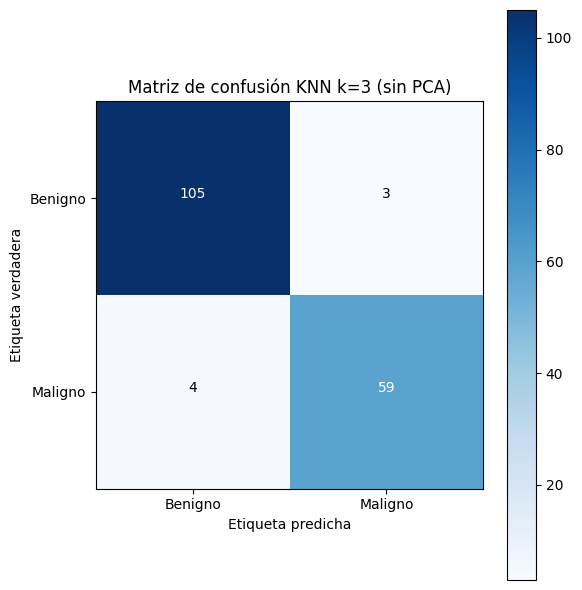

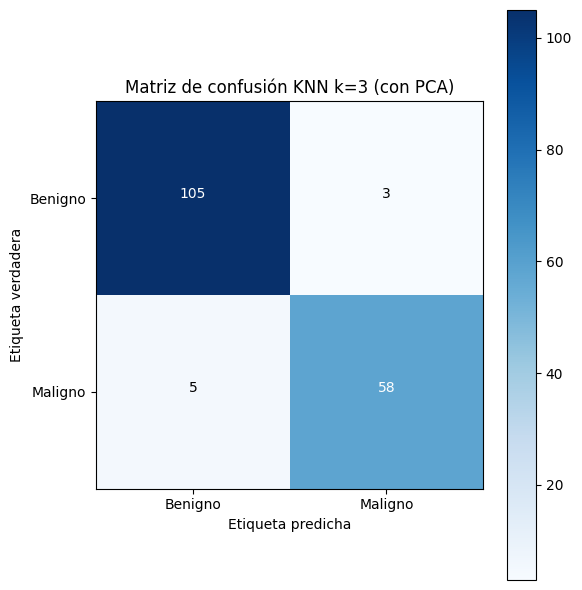

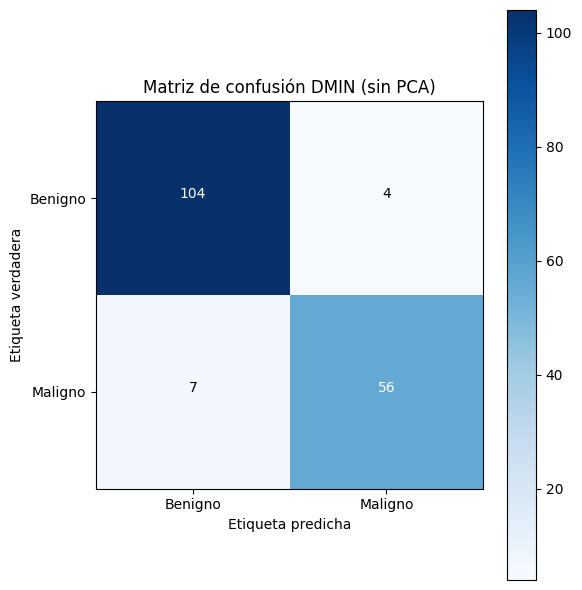

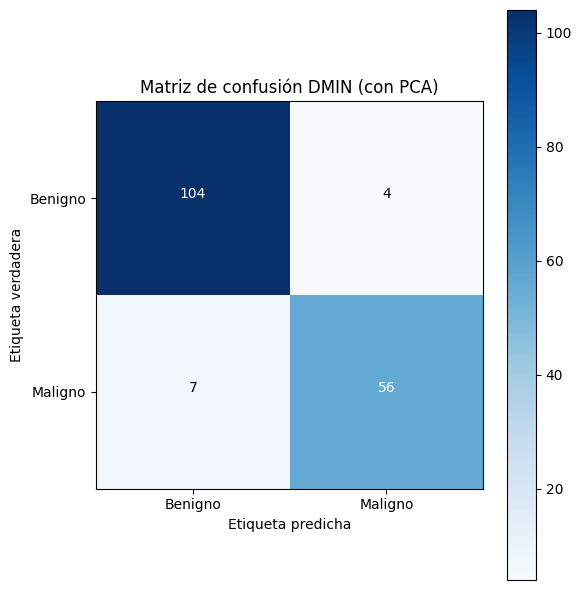

In [41]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Benigno', 'Maligno'])
    plt.yticks(tick_marks, ['Benigno', 'Maligno'])
    
    for i in range(2):
        for j in range(2):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > cm.max()/2 else "black")
    
    plt.ylabel('Etiqueta verdadera')
    plt.xlabel('Etiqueta predicha')
    plt.tight_layout()
    plt.show()

# Matriz de confusión para KNN k=3
plot_confusion_matrix(y_test, knn_models[3].predict(X_test), "Matriz de confusión KNN k=3 (sin PCA)")
plot_confusion_matrix(y_test, knn_pca_models[3].predict(X_test_pca), "Matriz de confusión KNN k=3 (con PCA)")

# Matriz de confusión para DMIN
plot_confusion_matrix(y_test, y_pred_dmin, "Matriz de confusión DMIN (sin PCA)")
plot_confusion_matrix(y_test, y_pred_dmin_pca, "Matriz de confusión DMIN (con PCA)")

## Ejercicio 2

In [44]:
column_names = ['ID', 'Diagnosis'] + [
    'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean',
    'compactness_mean', 'concavity_mean', 'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean',
    'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
    'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se', 'fractal_dimension_se',
    'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst',
    'compactness_worst', 'concavity_worst', 'concave_points_worst', 'symmetry_worst', 'fractal_dimension_worst'
]
df = pd.read_csv('wdbc.data', header=None, names=column_names)
X = df.iloc[:, 2:].values
y = df['Diagnosis'].values
y = np.where(y == 'M', 1, 0)  # Convertir a 1 (maligno) y 0 (benigno)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

### Entrenamiento de modelo SVM

In [45]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 1],
    'kernel': ['linear', 'rbf', 'poly']
}

svm = SVC(random_state=42)
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Mejor modelo
best_svm = grid_search.best_estimator_
print(f"\nMejores hiperparámetros: {grid_search.best_params_}")
print(f"Exactitud en validación cruzada: {grid_search.best_score_:.4f}")

# Reducción a 2D para visualización
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Entrenar SVM en espacio reducido para visualización
svm_vis = SVC(**grid_search.best_params_, random_state=42)
svm_vis.fit(X_train_pca, y_train)


Mejores hiperparámetros: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Exactitud en validación cruzada: 0.9748


SVC(C=1, kernel='linear', random_state=42)

### Visualización de resultados

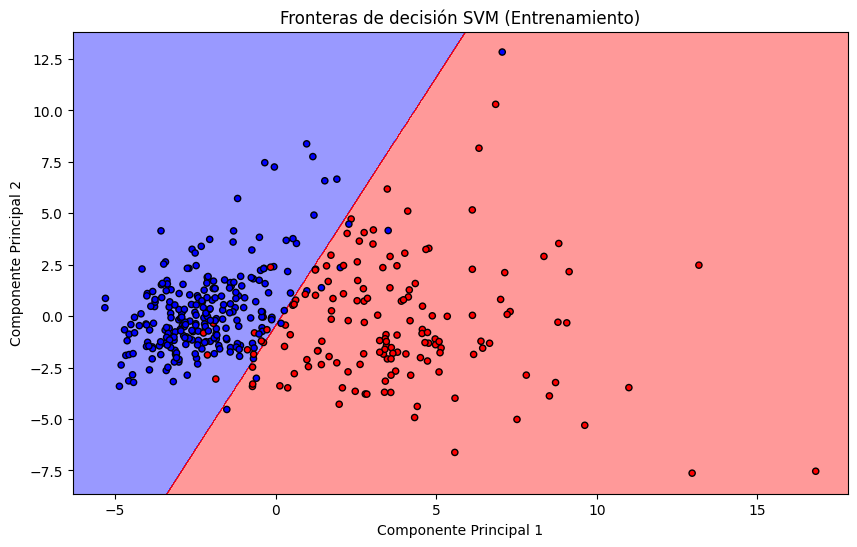

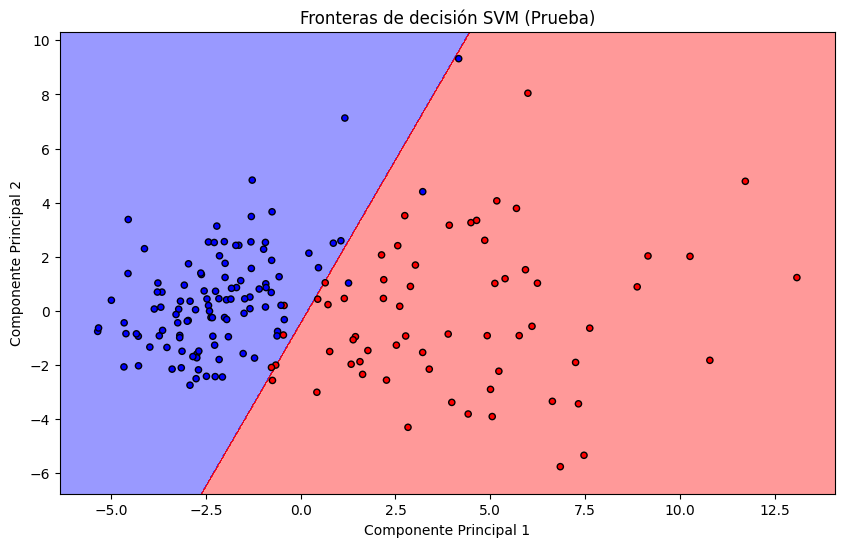

In [47]:
def plot_decision_boundary(model, X, y, title):
    h = .02  # step size
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap=ListedColormap(('blue', 'red')))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k', cmap=ListedColormap(('blue', 'red')))
    plt.title(title)
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.show()

plot_decision_boundary(svm_vis, X_train_pca, y_train, "Fronteras de decisión SVM (Entrenamiento)")
plot_decision_boundary(svm_vis, X_test_pca, y_test, "Fronteras de decisión SVM (Prueba)")

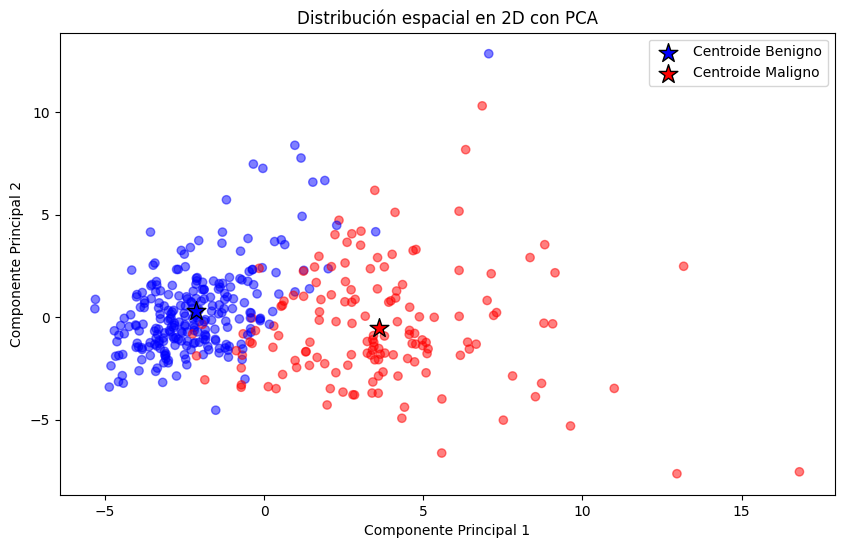

In [48]:
# Distribución espacial y centroides
centroid_benign = X_train_pca[y_train == 0].mean(axis=0)
centroid_malign = X_train_pca[y_train == 1].mean(axis=0)

plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap=ListedColormap(('blue', 'red')), alpha=0.5)
plt.scatter(centroid_benign[0], centroid_benign[1], s=200, marker='*', c='blue', edgecolor='k', label='Centroide Benigno')
plt.scatter(centroid_malign[0], centroid_malign[1], s=200, marker='*', c='red', edgecolor='k', label='Centroide Maligno')
plt.title('Distribución espacial en 2D con PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.show()

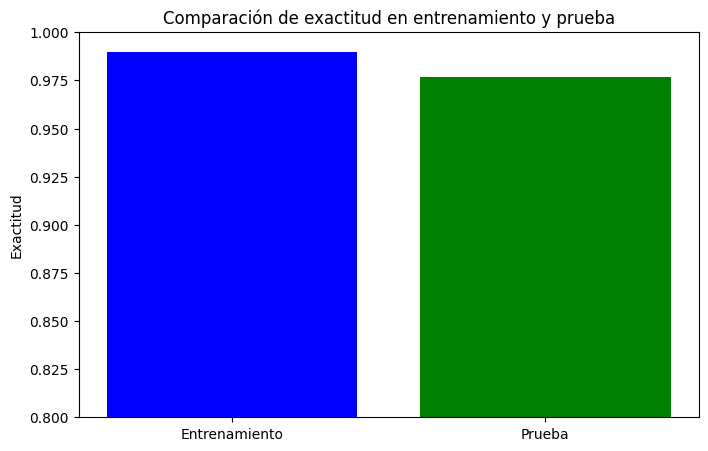

In [49]:
# Gráfico comparativo de rendimiento
y_pred_train = best_svm.predict(X_train)
y_pred_test = best_svm.predict(X_test)

accuracies = {
    'Entrenamiento': accuracy_score(y_train, y_pred_train),
    'Prueba': accuracy_score(y_test, y_pred_test)
}

plt.figure(figsize=(8, 5))
plt.bar(accuracies.keys(), accuracies.values(), color=['blue', 'green'])
plt.ylim(0.8, 1.0)
plt.ylabel('Exactitud')
plt.title('Comparación de exactitud en entrenamiento y prueba')
plt.show()

### Analisis de Resultados

In [50]:
print("\nReporte de clasificación (Prueba):")
print(classification_report(y_test, y_pred_test))


Reporte de clasificación (Prueba):
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       108
           1       0.97      0.97      0.97        63

    accuracy                           0.98       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.98      0.98      0.98       171



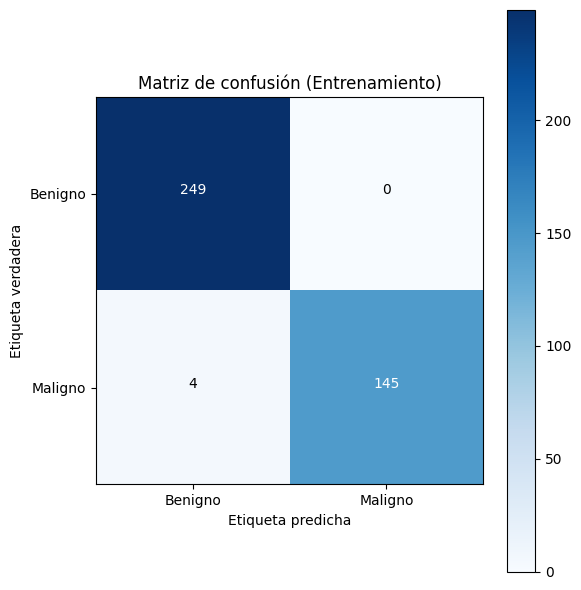

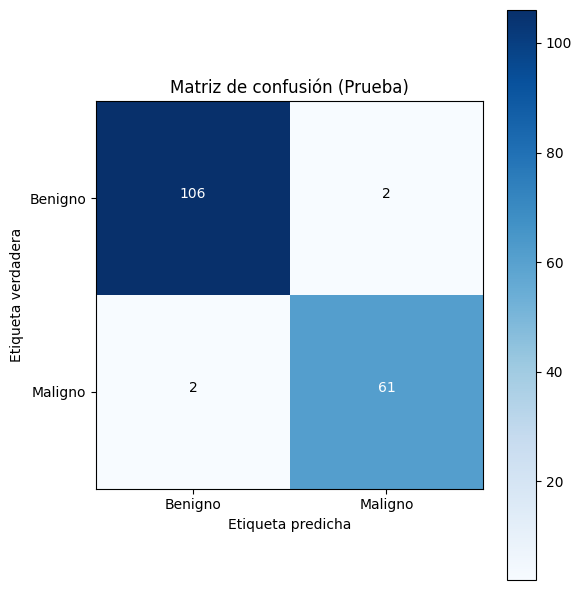

: 

In [ ]:
# Matrices de confusión
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Benigno', 'Maligno'])
    plt.yticks(tick_marks, ['Benigno', 'Maligno'])
    
    for i in range(2):
        for j in range(2):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > cm.max()/2 else "black")
    
    plt.ylabel('Etiqueta verdadera')
    plt.xlabel('Etiqueta predicha')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(y_train, y_pred_train, "Matriz de confusión (Entrenamiento)")
plot_confusion_matrix(y_test, y_pred_test, "Matriz de confusión (Prueba)")

## Ejercicio 3

### (a) Carga y limpieza de datos

In [ ]:
df = pd.read_csv('Wine.csv')

# Verificar y limpiar datos
print("\nInformación del dataset:")
print(df.info())
print("\nValores faltantes por columna:")
print(df.isnull().sum())
print("\nEstadísticas descriptivas:")
print(df.describe())

# Dividir el conjunto de datos
X = df.drop('Customer_Segment', axis=1)
y = df['Customer_Segment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(f"\nTamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de prueba: {X_test.shape}")


Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Alcohol               178 non-null    float64
 1   Malic_Acid            178 non-null    float64
 2   Ash                   178 non-null    float64
 3   Ash_Alcanity          178 non-null    float64
 4   Magnesium             178 non-null    int64  
 5   Total_Phenols         178 non-null    float64
 6   Flavanoids            178 non-null    float64
 7   Nonflavanoid_Phenols  178 non-null    float64
 8   Proanthocyanins       178 non-null    float64
 9   Color_Intensity       178 non-null    float64
 10  Hue                   178 non-null    float64
 11  OD280                 178 non-null    float64
 12  Proline               178 non-null    int64  
 13  Customer_Segment      178 non-null    int64  
dtypes: float64(11), int64(3)
memory usage: 19.6 KB
N

### (b) Preprocesamiento

In [3]:
# Para GaussianNB: Estandarización (media=0, std=1)
scaler_gaussian = StandardScaler()
X_train_gaussian = scaler_gaussian.fit_transform(X_train)
X_test_gaussian = scaler_gaussian.transform(X_test)

# Para MultinomialNB: Escalado a valores no negativos
scaler_multinomial = MinMaxScaler()
X_train_multinomial = scaler_multinomial.fit_transform(X_train)
X_test_multinomial = scaler_multinomial.transform(X_test)

### (c) Entrenamiento de modelos

In [4]:
# GaussianNB
gnb = GaussianNB()
gnb.fit(X_train_gaussian, y_train)

# MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train_multinomial, y_train)

MultinomialNB()

Explicación de hiperparámetros:

- GaussianNB no tiene hiperparámetros importantes para ajustar
- MultinomialNB tiene alpha (parámetro de suavizado Laplace) que por defecto es 1
- Usamos los valores por defecto ya que no tenemos razones específicas para modificarlo

### (d) Visualización de resultados

In [5]:
# Reducción de dimensionalidad para visualización
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_gaussian)

# Entrenar modelos en las 2 componentes principales para visualización
gnb_pca = GaussianNB()
gnb_pca.fit(X_train_pca, y_train)

GaussianNB()

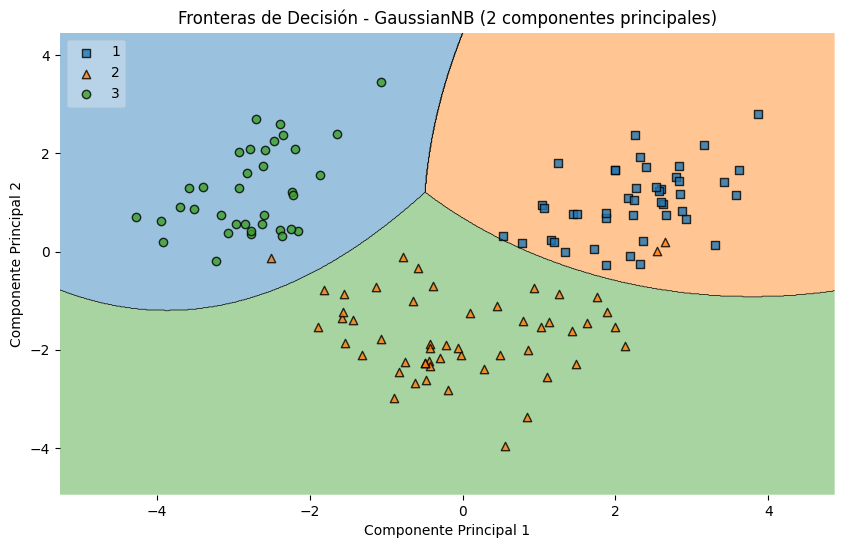

In [6]:
# i. Fronteras de decisión
plt.figure(figsize=(10, 6))
plot_decision_regions(X_train_pca, y_train.values, clf=gnb_pca, legend=2)
plt.title('Fronteras de Decisión - GaussianNB (2 componentes principales)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()

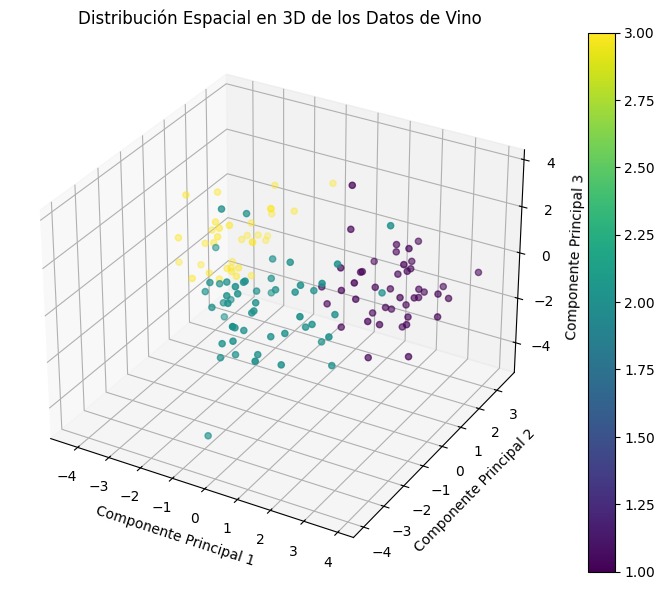

In [7]:
# ii. Distribución espacial en 3D
pca_3d = PCA(n_components=3)
X_train_pca_3d = pca_3d.fit_transform(X_train_gaussian)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_train_pca_3d[:, 0], X_train_pca_3d[:, 1], X_train_pca_3d[:, 2], c=y_train, cmap='viridis')
ax.set_title('Distribución Espacial en 3D de los Datos de Vino')
ax.set_xlabel('Componente Principal 1')
ax.set_ylabel('Componente Principal 2')
ax.set_zlabel('Componente Principal 3')
plt.colorbar(scatter)
plt.show()

### (e) Análisis de resultados

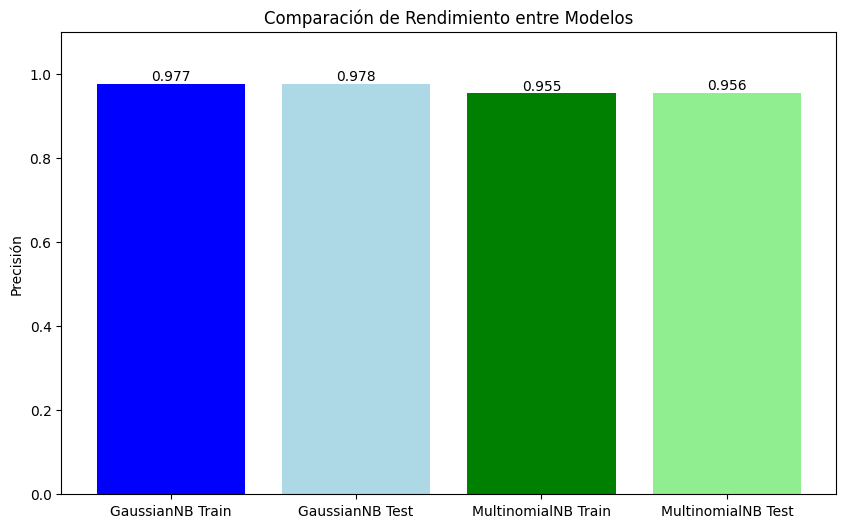

In [10]:
# Predecir en conjuntos de entrenamiento y prueba
y_train_pred_gnb = gnb.predict(X_train_gaussian)
y_test_pred_gnb = gnb.predict(X_test_gaussian)

y_train_pred_mnb = mnb.predict(X_train_multinomial)
y_test_pred_mnb = mnb.predict(X_test_multinomial)
# Evaluación de los modelos
acc_train_gnb = accuracy_score(y_train, y_train_pred_gnb)
acc_test_gnb = accuracy_score(y_test, y_test_pred_gnb)

acc_train_mnb = accuracy_score(y_train, y_train_pred_mnb)
acc_test_mnb = accuracy_score(y_test, y_test_pred_mnb)

# Gráfico de barras comparativo
models = ['GaussianNB Train', 'GaussianNB Test', 'MultinomialNB Train', 'MultinomialNB Test']
accuracies = [acc_train_gnb, acc_test_gnb, acc_train_mnb, acc_test_mnb]

plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=['blue', 'lightblue', 'green', 'lightgreen'])
plt.title('Comparación de Rendimiento entre Modelos')
plt.ylabel('Precisión')
plt.ylim(0, 1.1)

# Añadir valores en las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom')

plt.show()


Matriz de confusión - GaussianNB (Test):


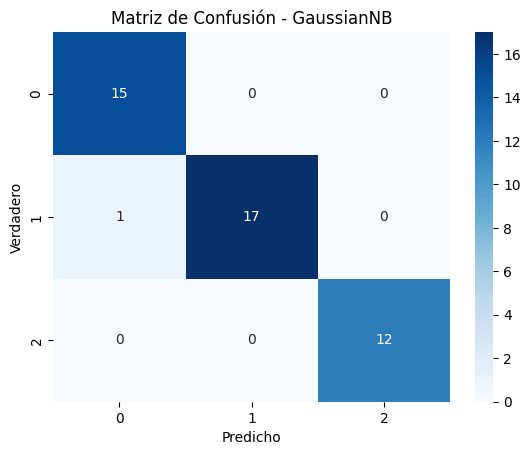


Matriz de confusión - MultinomialNB (Test):


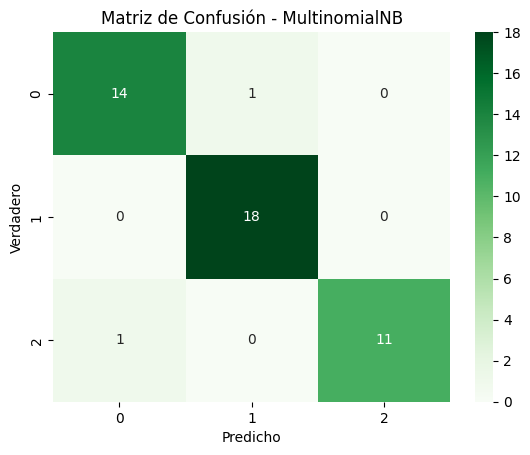

In [12]:
# ii. Matrices de confusión
print("\nMatriz de confusión - GaussianNB (Test):")
cm_gnb = confusion_matrix(y_test, y_test_pred_gnb)
sns.heatmap(cm_gnb, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - GaussianNB')
plt.ylabel('Verdadero')
plt.xlabel('Predicho')
plt.show()

print("\nMatriz de confusión - MultinomialNB (Test):")
cm_mnb = confusion_matrix(y_test, y_test_pred_mnb)
sns.heatmap(cm_mnb, annot=True, fmt='d', cmap='Greens')
plt.title('Matriz de Confusión - MultinomialNB')
plt.ylabel('Verdadero')
plt.xlabel('Predicho')
plt.show()


In [13]:

# Reportes de clasificación
print("\nReporte de clasificación - GaussianNB:")
print(classification_report(y_test, y_test_pred_gnb))

print("\nReporte de clasificación - MultinomialNB:")
print(classification_report(y_test, y_test_pred_mnb))


Reporte de clasificación - GaussianNB:
              precision    recall  f1-score   support

           1       0.94      1.00      0.97        15
           2       1.00      0.94      0.97        18
           3       1.00      1.00      1.00        12

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45


Reporte de clasificación - MultinomialNB:
              precision    recall  f1-score   support

           1       0.93      0.93      0.93        15
           2       0.95      1.00      0.97        18
           3       1.00      0.92      0.96        12

    accuracy                           0.96        45
   macro avg       0.96      0.95      0.95        45
weighted avg       0.96      0.96      0.96        45



## Ejercicio 4

### (a) Carga y limpieza de datos

In [15]:
iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
target_names = iris.target_names

df = pd.DataFrame(X, columns=feature_names)
df['target'] = y
df['species'] = df['target'].map({0: target_names[0], 1: target_names[1], 2: target_names[2]})

print("\nInformación del dataset:")
print(df.info())
print("\nValores faltantes por columna:")
print(df.isnull().sum())
print("\nNúmero de duplicados:", df.duplicated().sum())

df = df.drop_duplicates()
print("\nTamaño del dataset después de eliminar duplicados:", df.shape)


Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    int64  
 5   species            150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB
None

Valores faltantes por columna:
sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
target               0
species              0
dtype: int64

Número de duplicados: 1

Tamaño del dataset después de eliminar duplicados: (149, 6)


### (b) Preprocesamiento

In [16]:
# i. Estandarizar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[feature_names])

# ii. Dividir el conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(X_scaled, df['target'], 
                                                   test_size=0.2, 
                                                   random_state=42, 
                                                   stratify=df['target'])

print(f"\nTamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de prueba: {X_test.shape}")


Tamaño del conjunto de entrenamiento: (119, 4)
Tamaño del conjunto de prueba: (30, 4)


### (c) Entrenamiento del modelo de Árboles de decisión


Exactitud en entrenamiento: 0.9831932773109243
Exactitud en prueba: 0.9666666666666667

Matriz de confusión (test):


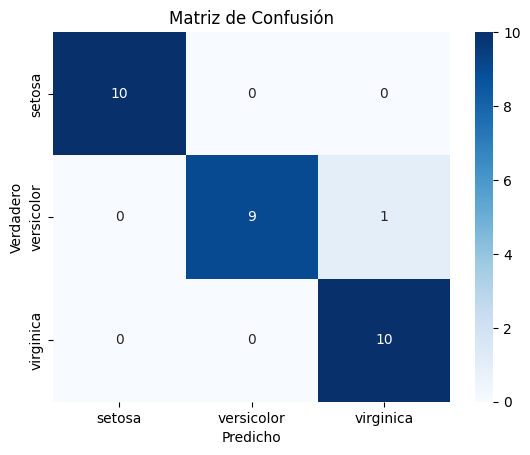

In [17]:
dtree = DecisionTreeClassifier(max_depth=3, random_state=42)
dtree.fit(X_train, y_train)

y_train_pred = dtree.predict(X_train)
y_test_pred = dtree.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("\nExactitud en entrenamiento:", train_accuracy)
print("Exactitud en prueba:", test_accuracy)

# Matriz de confusión
print("\nMatriz de confusión (test):")
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, 
            yticklabels=target_names)
plt.title('Matriz de Confusión')
plt.ylabel('Verdadero')
plt.xlabel('Predicho')
plt.show()

### (d) Visualización de resultados

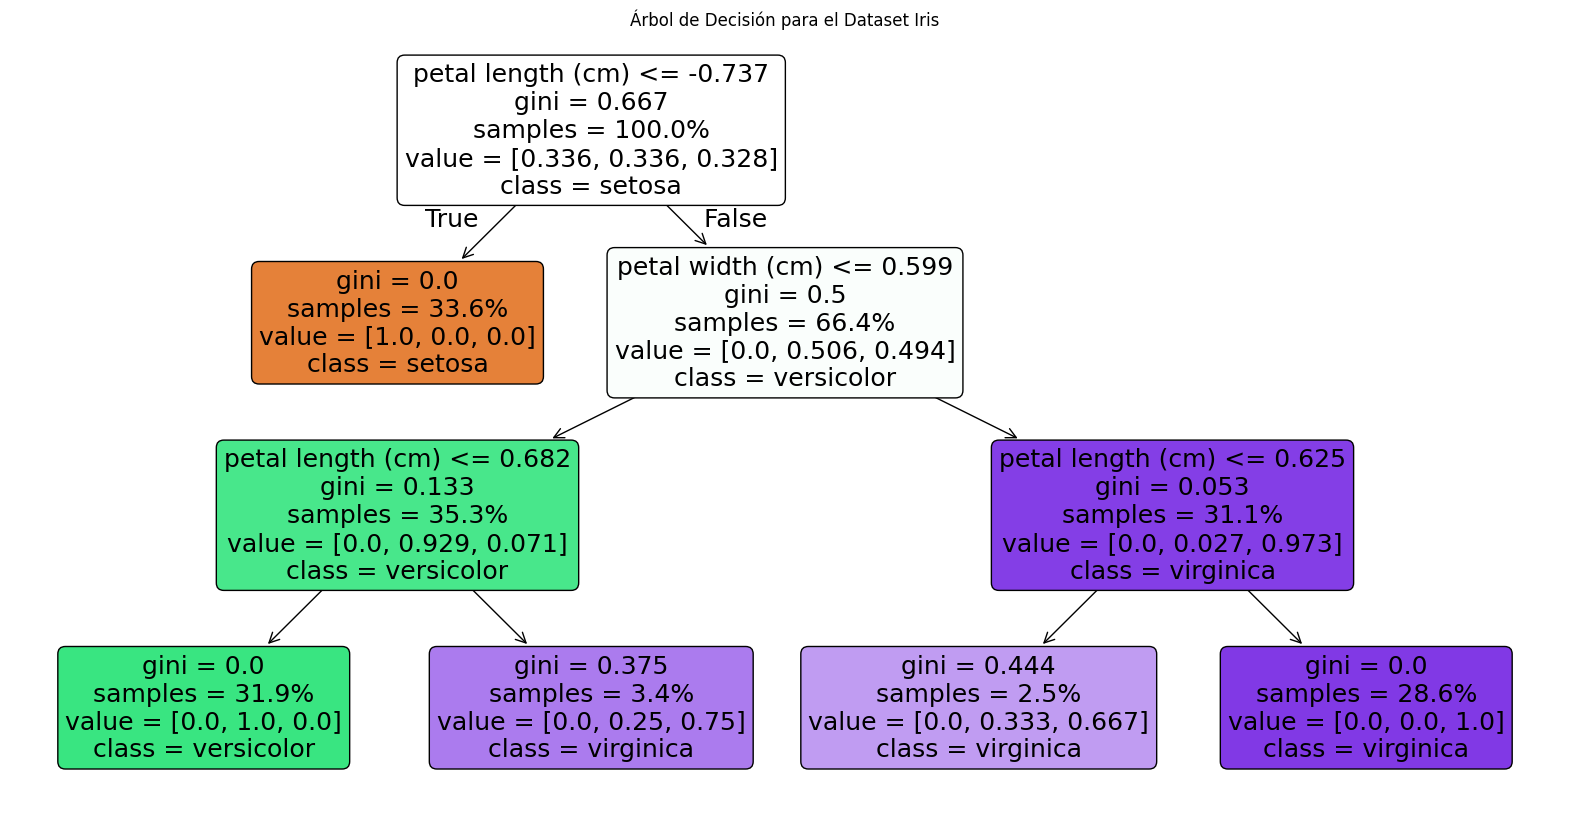

In [18]:
plt.figure(figsize=(20, 10))
plot_tree(dtree, 
          feature_names=feature_names, 
          class_names=target_names,
          filled=True, 
          rounded=True,
          proportion=True)
plt.title("Árbol de Decisión para el Dataset Iris")
plt.show()

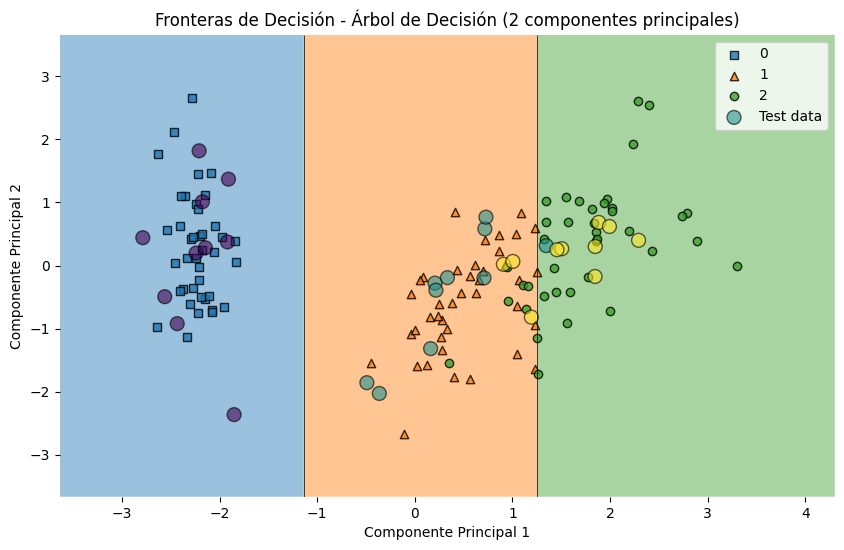

In [19]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

# Entrenar un nuevo árbol en las componentes principales para visualización
dtree_pca = DecisionTreeClassifier(max_depth=3, random_state=42)
dtree_pca.fit(X_train_pca, y_train)

plt.figure(figsize=(10, 6))
plot_decision_regions(X_train_pca, y_train.values, clf=dtree_pca, legend=2)
plt.title('Fronteras de Decisión - Árbol de Decisión (2 componentes principales)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')

# Marcar también los puntos de prueba
X_test_pca = pca.transform(X_test)
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, 
            edgecolors='k', marker='o', s=100, 
            linewidth=1, label='Test data', alpha=0.6)
plt.legend()
plt.show()

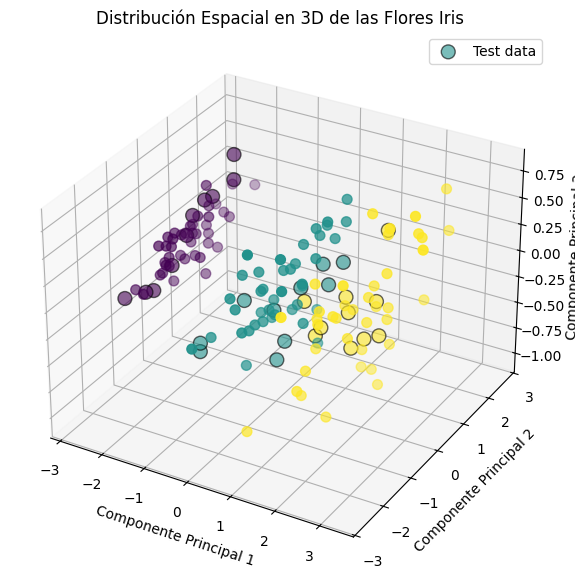

In [20]:
pca_3d = PCA(n_components=3)
X_train_pca_3d = pca_3d.fit_transform(X_train)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_train_pca_3d[:, 0], X_train_pca_3d[:, 1], X_train_pca_3d[:, 2], 
                    c=y_train, cmap='viridis', s=50)
ax.set_title('Distribución Espacial en 3D de las Flores Iris')
ax.set_xlabel('Componente Principal 1')
ax.set_ylabel('Componente Principal 2')
ax.set_zlabel('Componente Principal 3')

# Añadir puntos de prueba
X_test_pca_3d = pca_3d.transform(X_test)
ax.scatter(X_test_pca_3d[:, 0], X_test_pca_3d[:, 1], X_test_pca_3d[:, 2], 
           c=y_test, cmap='viridis', s=100, edgecolors='k', marker='o', 
           linewidth=1, alpha=0.6, label='Test data')

plt.legend()
plt.show()

In [21]:
# Reporte de clasificación detallado
print("\nReporte de clasificación:")
print(classification_report(y_test, y_test_pred, target_names=target_names))


Reporte de clasificación:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.90      0.95        10
   virginica       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



# V Concluiones

La práctica permitió no solo evaluar el desempeño aislado de cada modelo, sino también contrastar sus ventajas y limitaciones. Esto evidenció que no existe un único modelo superior en todos los casos, sino que la elección del clasificador debe considerar las características específicas del conjunto de datos, como su dimensionalidad, balance de clases y complejidad de las fronteras de decisión.

Ahora bien tambien vemos que muchos modelos, como KNN y SVM, son altamente sensibles a la selección de hiperparámetros (como k en KNN o el kernel y C en SVM). Un ajuste inadecuado puede degradar significativamente el desempeño, mientras que una correcta optimización puede marcar la diferencia entre un modelo mediocre y uno sobresaliente.

Nos damos cuenta que la limpieza y normalización,las transformaciones como la reducción de dimensionalidad no solo ayudan a la visualización, sino que también impacta en la eficiencia y rendimiento de los clasificadores, al eliminar redundancia y ruido.

Ademas vemos los modelos como los árboles de decisión permiten una interpretación clara de las reglas subyacentes, lo cual es valioso en aplicaciones donde la explicabilidad es prioritaria. Sin embargo, en términos de rendimiento puro, otros modelos como SVM pueden superar a los árboles, aunque a costa de una menor interpretabilidad.

La práctica permitió observar cómo algunos modelos tienden a sobreajustarse (especialmente los árboles de decisión sin poda o SVM mal configurados), mientras que otros, como Naive Bayes, tienden a generalizar mejor en conjuntos pequeños, incluso si no alcanzan la máxima exactitud.

Finalmente, trabajar con datasets clásicos sirvió como un excelente laboratorio para experimentar, pero también dejó claro que en problemas del mundo real se requerirá una preparación aún más meticulosa, incluyendo manejo de datos faltantes, codificación de variables categóricas y evaluación con métricas más allá de la simple exactitud (como precisión, recall y F1-score).




# Referencias

- Tolstikhin, Ilya O., et al. \textit{Mlp-mixer: An all-mlp architecture for vision}. Advances in neural information processing systems 34 (2021): 24261-24272
- Wu, Baoyuan, et al. \textit{Defenses in adversarial machine learning: A survey}. arXiv preprint arXiv:2312.08890 (2023)
- Liu, Xiao, et al. \textit{Self-supervised learning: Generative or contrastive}. IEEE transactions on knowledge and data engineering 35.1 (2021): 857-876.
- Goodfellow, Ian. \textit{Deep learning.} (2016).
- Murphy, Kevin P. \textit{Machine learning: a probabilistic perspective}. MIT press, 2012.
-  Wolberg, W., Mangasarian, O., Street, N., & Street, W. (1993). Breast Cancer Wisconsin (Diagnostic) [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5DW2B.
- Cortez, P., Cerdeira, A., Almeida, F., Matos, T., & Reis, J. (2009). Wine Quality [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C56S3T.
-  Fisher, R. (1936). Iris [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C56C76.